In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import numpy as np
import seaborn
import matplotlib.pyplot as plt


In [2]:
import os
import glob

path = 'dataset\\cstyle_dataset\\'
all_files = glob.glob(os.path.join(path, "*.txt")) 

frames = []
for f in all_files:
    file_df = pd.read_csv(f, header=None, index_col=None, sep='\n', names=['text'], engine='python')
    labels = [f.replace(path+'jstor_', '').replace('.txt', '') for x in range(len(file_df))]
    file_df['label'] = labels
    frames.append(file_df)
    
df   = pd.concat(frames, axis=0, ignore_index=True)
df

,text,label
0,"[1]T., V. and Quinney, D. 1987. An Introductio...",acm-sig-proceedings
1,"[1]Pope, S.T. et al. 1995. Touched by Machine?...",acm-sig-proceedings
2,"[1]Sugihara, M. and Murota, K. 1982. A Note on...",acm-sig-proceedings
3,"[1]Franklin, J.N. et al. 1965. Monte Carlo Met...",acm-sig-proceedings
4,"[1]Kitchen, J. and Denbaly, M. 1987. Commodity...",acm-sig-proceedings
...,...,...
50098,"Freedman, Marcia, and James G. Scoville. “The ...",mla
50099,"Smoliar, Stephen W., and Deryck Cooke. “The La...",mla
50100,"L., Y. L., and F. M. Arscott. “Periodic Differ...",mla
50101,"Katz, Lawrence F. “Some Recent Developments in...",mla


In [3]:
''' Create training and test dataset'''
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.text, df.label, test_size=0.25, random_state=42)

In [4]:
print(y_train.value_counts())
print(y_test.value_counts())
print(type(y_test.value_counts()))

mla                          5513
chicago-author-date          5415
american-chemical-society    5400
ieee                         5361
apa                          5342
acm-sig-proceedings          5296
harvard3                     5250
Name: label, dtype: int64
harvard3                     1842
acm-sig-proceedings          1831
mla                          1819
apa                          1798
ieee                         1771
american-chemical-society    1740
chicago-author-date          1725
Name: label, dtype: int64
<class 'pandas.core.series.Series'>


In [11]:
#Check tfidf vocabulary
tfidf = TfidfVectorizer(lowercase=False, token_pattern=r"(?u)(\b\w+\b|[\.\"(),\'\[\]:;])")
tfidf.fit_transform(df.text)
tfidf.vocabulary_

{'[': 22814,
 '1': 10,
 ']': 22815,
 'T': 21122,
 '.': 4,
 ',': 3,
 'V': 21879,
 'and': 22838,
 'Quinney': 18892,
 'D': 11479,
 '1987': 843,
 'An': 9060,
 'Introduction': 14832,
 'to': 23301,
 'the': 23294,
 'Numerical': 17656,
 'Solution': 20526,
 'of': 23161,
 'Differential': 11856,
 'Equations': 12534,
 'Mathematics': 16593,
 'Computation': 11055,
 '48': 8040,
 '178': 713,
 '(': 1,
 'Apr': 9201,
 ')': 2,
 '833': 8496,
 'Pope': 18508,
 'S': 19647,
 'et': 23019,
 'al': 22828,
 '1995': 1342,
 'Touched': 21534,
 'by': 22877,
 'Machine': 16303,
 ':': 8665,
 'Composition': 11045,
 'Performance': 18222,
 'in': 23068,
 'Digital': 11872,
 'Age': 8870,
 'Computer': 11060,
 'Music': 17279,
 'Journal': 15129,
 '19': 758,
 '3': 6459,
 '13': 210,
 'Sugihara': 20981,
 'M': 16255,
 'Murota': 17268,
 'K': 15176,
 '1982': 838,
 'A': 8667,
 'Note': 17632,
 'on': 23166,
 'Haselgrove': 14042,
 's': 23224,
 'Method': 16859,
 'for': 23037,
 'Integration': 14769,
 '39': 7895,
 '160': 652,
 'Oct': 17713,
 '

In [13]:
''' Will try a few approaches to categorising citation styles.
    First will be a naive one -- take strings, get tfidf vectors, then feed into LR.
    Second will like the one in crossref -- just use the orthographic features.
    Open bracket, close bracket, open sqbracket, close sqbracket,
    number, capitalised word, word, uppercase letter, 
    fullstop/dot, comma, colon, semicolon, quotation marks'''
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, plot_confusion_matrix, confusion_matrix as cm
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('features', TfidfVectorizer(ngram_range=(1,3), lowercase=False, token_pattern=r"(?u)(\b\w+\b|[\.\"(),\'\[\]:;])")),
    ('scaler', StandardScaler(with_mean=False)),
    ('classifier', LogisticRegression(class_weight='balanced'))
])
params = {'classifier__C': [0.001],
         'classifier__max_iter': [500],}
gs = GridSearchCV(pipeline, params, refit=True, cv=2, scoring='f1_macro', verbose=10)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START classifier__C=0.001, classifier__max_iter=500...............
[CV 1/2; 1/1] END classifier__C=0.001, classifier__max_iter=500; total time=  37.2s
[CV 2/2; 1/1] START classifier__C=0.001, classifier__max_iter=500...............
[CV 2/2; 1/1] END classifier__C=0.001, classifier__max_iter=500; total time=  27.9s
Test F1 score: 0.998813875898996
[[1829    0    1    0    0    0    1]
 [   0 1740    0    0    0    0    0]
 [   0    0 1797    0    0    0    1]
 [   0    0    0 1724    1    0    0]
 [   1    0    3    0 1838    0    0]
 [   6    0    0    0    0 1765    0]
 [   0    0    0    1    0    0 1818]]


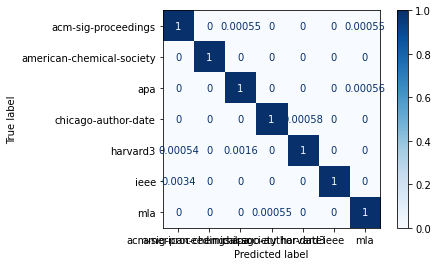

In [14]:
gs.fit(X_train, y_train)
y_pred = gs.predict(X_test)
score = f1_score(y_test, y_pred, average='macro')
cMtx = cm(y_test, y_pred)
print('Test F1 score: {}'.format(score))
print(cMtx)
plot_confusion_matrix(gs, X_test, y_test, normalize='true', cmap='Blues')
plt.show()

''' Naive solution seems to work pretty well. 
Will need to test with unseen text/different subjects to see if it generalizes well to other fields.'''

In [7]:
pipeline.get_params().keys() # For parameter optimization

dict_keys(['memory', 'steps', 'verbose', 'features', 'scaler', 'classifier', 'features__analyzer', 'features__binary', 'features__decode_error', 'features__dtype', 'features__encoding', 'features__input', 'features__lowercase', 'features__max_df', 'features__max_features', 'features__min_df', 'features__ngram_range', 'features__norm', 'features__preprocessor', 'features__smooth_idf', 'features__stop_words', 'features__strip_accents', 'features__sublinear_tf', 'features__token_pattern', 'features__tokenizer', 'features__use_idf', 'features__vocabulary', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'classifier__C', 'classifier__class_weight', 'classifier__dual', 'classifier__fit_intercept', 'classifier__intercept_scaling', 'classifier__l1_ratio', 'classifier__max_iter', 'classifier__multi_class', 'classifier__n_jobs', 'classifier__penalty', 'classifier__random_state', 'classifier__solver', 'classifier__tol', 'classifier__verbose', 'classifier__warm_start'])

In [8]:
''' load the saved model '''
from joblib import dump
dump(gs.best_estimator_, 'models\\cstyle_LR_punctuations.pkl')


['models\\cstyle_LR_punctuations.pkl']

In [9]:
'''Test with unseen texts from another subject matter'''

fpath = 'dataset\\jstor\\'
all_files = glob.glob(os.path.join(fpath, "unseen1000jstor_*.txt")) 
frames = []
for f in all_files:
    file_df = pd.read_csv(f, header=None, index_col=None, sep='\n', names=['text'], engine='python')
    labels = [f.replace(fpath+'unseen1000jstor_', '').replace('.txt', '') for x in range(len(file_df))]
    file_df['label'] = labels
    frames.append(file_df)

testdf   = pd.concat(frames, axis=0, ignore_index=True)
testdf

,text,label
0,"[1]Wohlfarth, I. 1986. Et Cetera? The Historia...",acm-sig-proceedings
1,"[1]CAPELOTTI, P.J. 2018. Adventures in Archaeo...",acm-sig-proceedings
2,"[1]Stephan, A. et al. 1974. Lyrik in der DDR: ...",acm-sig-proceedings
3,"[1]Leyva-Ríos, S. and Day, S. 2006. Staging Po...",acm-sig-proceedings
4,"[1]Lopes, F.C. 1989. Elegia para um poeta. Cha...",acm-sig-proceedings
...,...,...
6344,"Giglio, Sérgio Settani, and Marcelo Weishaupt ...",mla
6345,"Kaebnick, Suzanne. “The ‘Loca’ Freedom Fighter...",mla
6346,"Ortega, Francisco. “Excessive Friendships: Fac...",mla
6347,"Corbatta, Jorgelina. “Lo Que Va de Ayer a Hoy:...",mla


Test F1 score: 0.9831250672080497
[[907   0   0   0   0   0   0]
 [  2 897   8   0   0   0   0]
 [  0   0 901   5   0   0   1]
 [  0   0   0 907   0   0   0]
 [  0   0   0   1 906   0   0]
 [ 90   0   0   0   0 817   0]
 [  0   0   0   0   0   0 907]]


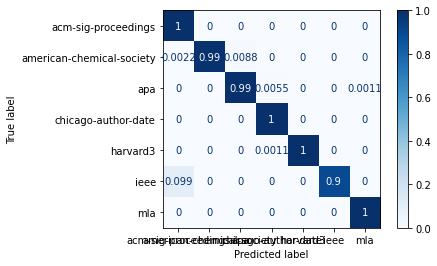

In [10]:
from joblib import load

gs = load('models\\cstyle_LR_punctuations.pkl')
y_unseen = gs.predict(testdf.text)
score = f1_score(testdf.label, y_unseen, average='macro')
cMtx = cm(testdf.label, y_unseen)
print('Test F1 score: {}'.format(score))
print(cMtx)
plot_confusion_matrix(gs, testdf.text, testdf.label, normalize='true', cmap='Blues')
plt.show()